# 삼성 주가 예측

data : 삼성 주가 예측<br>
출처 : Yahoo finance<br>
Box - Jenkins 방법론 과정을 따라서 시계열 분석하고 결과 예측하기

### ** Box-Jenkins 방법론 **

1. 식별
  - 자료의 시계열도, ACF, PACF 등 이용
  - 차분의 필요 여부와 모형의 차수를 잠정적으로 결정

2. 추정
  - 최소제곱법, 최대가능도법, 비선형최소제곱법 등 이용

3. 진단
  - 잔차의 시계열도, ACF, PACF 및 포트멘토 통계량을 이용한 잔차분석
  - AIC, SBC 등의 통계값 등을 이용해 가장 설명력 높은 모형 선택

4. 예측
  - 적합한 최종 모형으로 이후 값 예측

## 1. Data load

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,706 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128275 files and di

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')


df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

df = df[["Close"]]

df = df.reset_index()

df.columns = ['day', 'price']

df['day'] = pd.to_datetime(df['day'])

df.index = df['day']
df.set_index('day', inplace=True)

df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [3]:
df.isna().sum()

price    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


## 1. 식별

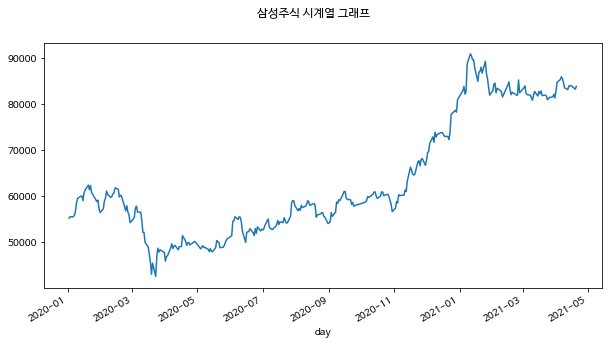

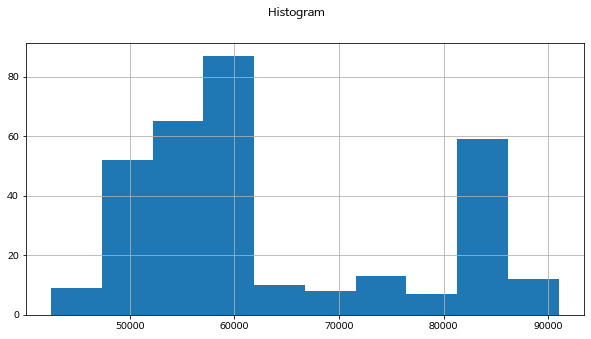

In [5]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('삼성주식 시계열 그래프')
df['price'].plot(ax=ax)
plt.show()

#Historgram
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Histogram')
df['price'].hist(ax=ax)
plt.show()

가격의 평균이 시간(월별)에 따라 일정하지 않기 때문에 비정상 시계열이다.

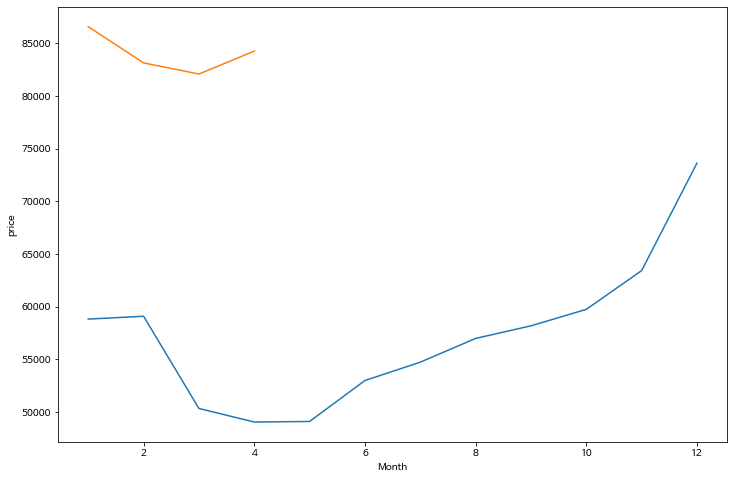

In [13]:
df['year'] = df.index.year
df['month'] = df.index.month
df_pivot = pd.pivot_table(df, values='price', index='month', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('price')
plt.show()

### ACF, PACF 그래프 확인

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


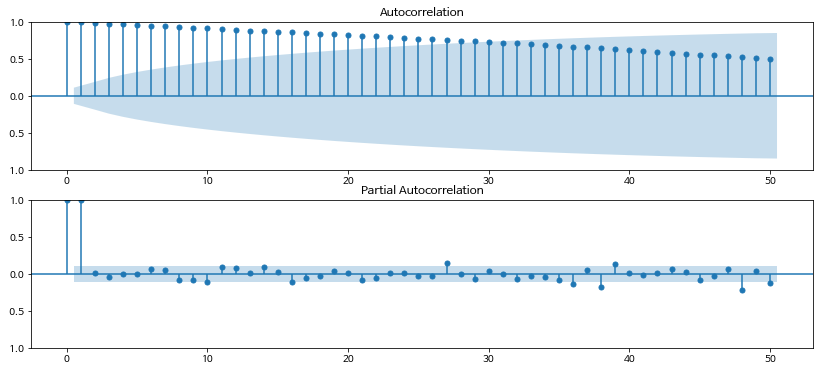

In [16]:
df.drop(['year', 'month'], axis=1, inplace=True)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
plt.show()

x축은 lag, y축은 correlation
ACF 그래프를 확인했을 때, 27까지는 파란색 범위에서 벗어난 것을 확인할 수 있었다. 이는 Auto correlation이 있다는 의미이다. 또한 전반적으로 매우 천천히 correlation이 내려감을 확인할 수 있다. 

또한 PACF그래프를 확인했을 때 시차 차이가 1인 것까지 coreelation이 높았다. 

### ADF 검정

In [23]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['price'])

(-0.21218947966329235,
 0.9370529809409828,
 0,
 321,
 {'1%': -3.450886958636161,
  '5%': -2.870586350823483,
  '10%': -2.5715897843576827},
 5192.408736501805)

p-value가 0.9371로 0.05 신뢰수준에서 0.9371 > 0.05이므로 귀무가설을 기각할 수 없다. 
- 귀무가설(H0) : 데이터가 정상성을 가지고 있지 않다.
- 대립가설(H1) : 데이터가 정상성을 가지고 있다.

<br>따라서 정상성을 갖는 시계열 데이터라고 판단할 수 있는 근거가 없다.

### 차분 통해 정상화

In [25]:
df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [34]:
import statsmodels.api as sm

# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = sm.tsa.arima.ARIMA(df, order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/l

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  322
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2736.984
Date:                Tue, 14 Mar 2023   AIC                           5483.969
Time:                        08:26:19   BIC                           5502.826
Sample:                             0   HQIC                          5491.498
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0662      1.937      0.034      0.973      -3.731       3.863
ar.L2          0.7292      1.732      0.421      0.674      -2.665       4.123
ma.L1         -0.0527      1.959     -0.027      0.9

예측값 구하기

In [37]:
fcast1 = model_fit.predict()
fcast1

day
2020-01-02        0.000000
2020-01-03    55685.662422
2020-01-06    56146.349980
2020-01-07    55884.303351
2020-01-08    56283.765615
                  ...     
2021-04-14    84004.170516
2021-04-15    84008.761968
2021-04-16    84104.770908
2021-04-19    83905.561232
2021-04-20    83292.129945
Name: predicted_mean, Length: 322, dtype: float64

In [38]:
fcast1 = pd.DataFrame(fcast1)
fcast1.columns = ['price']
fcast1

,price
day,
2020-01-02,0.000000
2020-01-03,55685.662422
2020-01-06,56146.349980
2020-01-07,55884.303351
2020-01-08,56283.765615
...,...
2021-04-14,84004.170516
2021-04-15,84008.761968
2021-04-16,84104.770908


원래 데이터와 예측값 확인

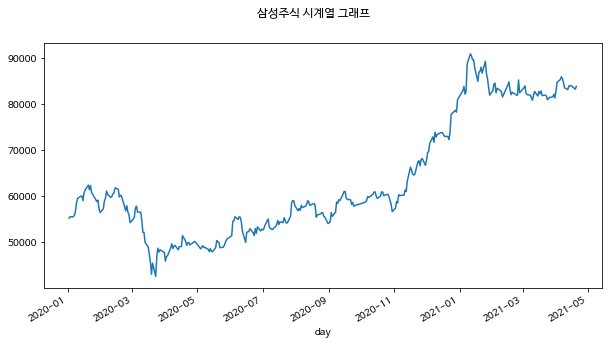

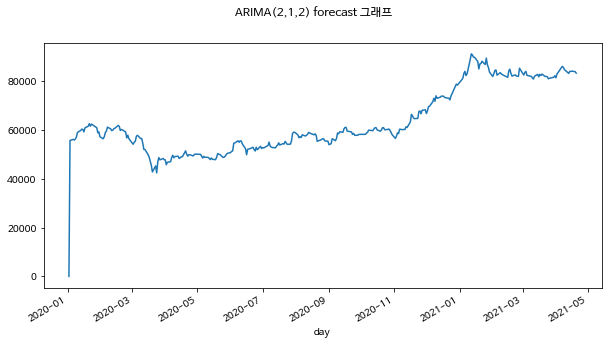

In [39]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('삼성주식 시계열 그래프')
df['price'].plot(ax=ax)
plt.show()

#Historgram
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('ARIMA(2,1,2) forecast 그래프')
fcast1['price'].plot(ax=ax)
plt.show()


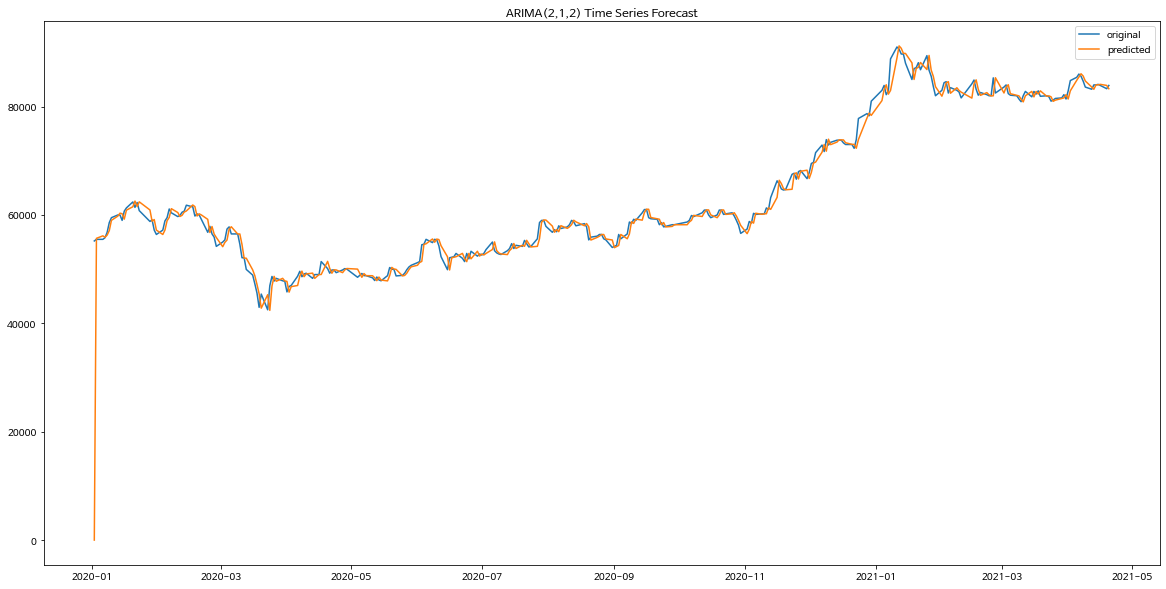

In [41]:
# 한꺼번에 보기
plt.figure(figsize=(20,10))
plt.plot(df.index, df.price, label='original')
plt.plot(fcast1.index, fcast1.price, label='predicted')
plt.title('ARIMA(2,1,2) Time Series Forecast')
plt.legend()
plt.show()

눈으로 확인했을 때 original(원래값)과 크게 다르지 않음을 확인할 수 있었다. 즉, 알맞게 예측되었다고 판단할 수 있다.

### ADF 검정 통해 정상 시계열이 됐는지 확인

In [42]:
from statsmodels.tsa.stattools import adfuller

adfuller(fcast1['price'])

(-4.632541000386583,
 0.00011245865324822545,
 0,
 321,
 {'1%': -3.450886958636161,
  '5%': -2.870586350823483,
  '10%': -2.5715897843576827},
 5200.3523465296275)

ADF 검정의 p-value는 0.0001로 유의수준 0.05하에서 0.0001 < 0.05이므로 귀무가설을 기각한다.<br> 따라서 예측데이터는 정상성을 가진다고 말할 충분한 근거가 있다.

ACF 그래프 확인

In [48]:
fcast1

,price
day,
2020-01-02,0.000000
2020-01-03,55685.662422
2020-01-06,56146.349980
2020-01-07,55884.303351
2020-01-08,56283.765615
...,...
2021-04-14,84004.170516
2021-04-15,84008.761968
2021-04-16,84104.770908


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


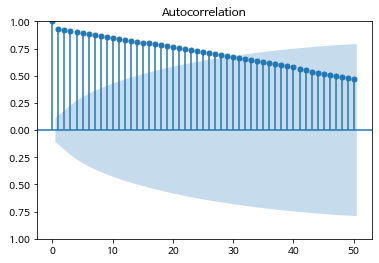

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


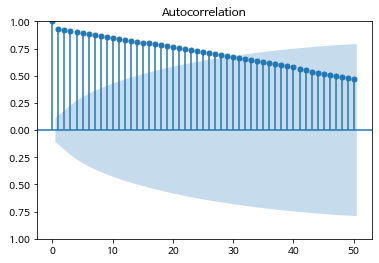

In [56]:
plot_acf(fcast1, lags=50)

## 2. 추정
auto_arima를 이용해서 최적의 ARIMA 모형 찾기. 

In [16]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00


In [17]:
import pmdarima as pm

<AxesSubplot:xlabel='day'>

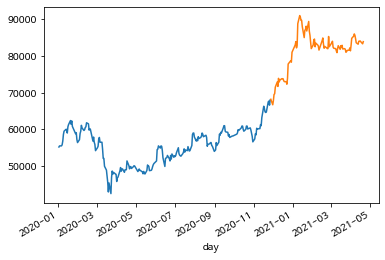

In [33]:
y_train = df['price'][:int(0.7*len(df))]
y_test = df['price'][int(0.7*len(df)):]
y_train.plot()
y_test.plot()

In [18]:
model = pm.auto_arima(y = y_train 
                      ,d = 1            # 차분 차수 = 1
                      ,start_p = 0 
                      ,max_p = 3   
                      ,start_q = 0 
                      ,max_q = 3   
                      ,m = 1       
                      ,seasonal = False # 계절성 ARIMA가 아니라서
                      ,stepwise = True
                      ,trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3786.147, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3788.102, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3788.126, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3784.728, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3790.088, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.447 seconds


In [19]:
model = pm.auto_arima(df['price'], d=1, D=1,seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5490.043, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5463.247, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5451.415, Time=0.88 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5490.070, Time=0.34 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=7.96 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5427.298, Time=9.83 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=17.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5426.596, Time=5.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5443.980, Time=2.72 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=5430.269, Time=6.09 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5427.028, Time=3.28 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5437.785, Time=4.71 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=5426.596, Time=3.12 sec

Best model:  ARIMA(0,1,0)(0,1,2)

AIC 로 비교했을 때 AIC가 가장 작은 **ARIMA(0,1,0)(0,1,2)[12]** 모형이 최종 모형이 되었다.
<br>
model의 summary 결과를 확인했을 때,
Ljung-Box(Q)의 p-value가 0.24로 유의수준 0.05에서 귀무가설을 기각하지 못한다. 해당 검정의 귀무가설은 "잔차가 white noise 시계열을 따른다."이므로 귀무가설이 기각되지 못했으므로 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기 상관을 가지지 않는 white noise임을 알 수 있다.<br>
또한 Jarque-Bera(JB) p-value를 보면 0.00으로 유의수준 0.05에서 귀무가설을 기각한다. 이 검정의 귀무가설은 "잔차가 정규성을 만족한다."이므로 귀무가설을 기각했으므로 잔차가 정규성을 따르지 않는다는 사실을 알 수 있다. 

또한 Skew는 -0.30으로 0에 가깝지만 Kurtosis는 5.49로 3에 가깝지 않은 것을 알 수 있다. 따라서 잔차가 완전히 정규분포를 따른다고 볼 순 없다.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


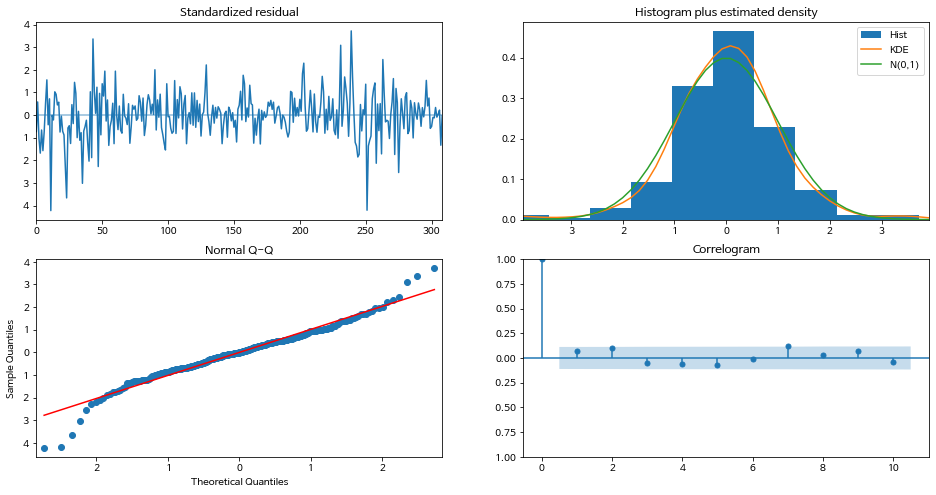

In [20]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

Standardized residual plot을 통해 white noise 의 모양을 띔을 알 수 있었고, Correlogram을 통해 잔차에 대한 ACF를 확인하여 신뢰구간 안에 대부분 들어옴을 확인했다. 따라서 자기상관이 없음을 확인할 수 있었다.<br>

Histogram plus estimated density plot을 통해 잔차가 정규분포형태를 띄는지를 확인하였고, 정규분포보다는 조금 뾰족한 형태임을 확인할 수 있는데, 위에 summary에서 첨도가 3보다 크다는 사실을 시각적으로 확인할 수 있었다.
Normal Q-Q 그래프를 통해 대부분 빨간 선을 따랐지만 양 끝에서 선을 벗어나는 모습을 확인했다.
<br><br>
결론적으로 ARIMA(0,1,0) 모형은 잔차는 white noise지만 정규성은 따르지 않음을 알 수 있다.

In [21]:
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


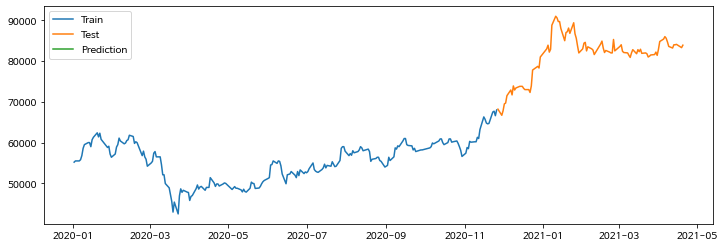

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        
plt.plot(y_test, label='Test')          
plt.plot(y_predict, label='Prediction')  
plt.legend()
plt.show()

해당 데이터는 특정한 주기나 추세가 없기 때문에 AR이나 MA를 찾기 어렵다. <br>
따라서 한번에 테스트 데이터를 예측하는 것이 아니라 한 스텝씩 예측하고 테스트 데이터를 관측할 때마다 모형을 업데이트해주는 Refresh 전략 활용해보았다.

In [28]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 전체 길이만 예측하는게 아니라 1개씩만 예측
        , return_conf_int=True)              
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [34]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트
    model.update(new_ob)

In [35]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
day,,
2020-11-27,68200.0,83805.105399
2020-11-30,66700.0,68751.003701
2020-12-01,67800.0,66287.875050
2020-12-02,69500.0,66998.792560
2020-12-03,69700.0,68615.513991
...,...,...
2021-04-14,84000.0,83821.487319
2021-04-15,84100.0,83911.795107
2021-04-16,83900.0,84022.405739


오늘의 실제값 =  내일의 예측값

In [71]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  419
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -3632.897
Date:                                 Tue, 14 Mar 2023   AIC                           7273.795
Time:                                         10:09:15   BIC                           7289.820
Sample:                                              0   HQIC                          7280.137
                                                 - 419                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -34.8745     12.311     -2.833      0.005     -59.003     -10

model의 summary 결과를 확인했을 때,
Ljung-Box(Q)의 p-value가 0.15로 유의수준 0.05에서 귀무가설을 기각하지 못한다. 따라서 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기 상관을 가지지 않는 white noise임을 알 수 있다.<br>
또한 Jarque-Bera(JB) p-value를 보면 0.00으로 유의수준 0.05에서 귀무가설을 기각한다. 따라서 잔차가 정규성을 따르지 않는다는 사실을 알 수 있다. 

또한 Skew와 Kurtosis는 아까보다 각각 0과 3에서 더 멀어진 것을 확인할 수 있었다. 따라서 잔차의 정규성을 개선하는데에는 효과가 없었음을 확인할 수 있었다.

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] 
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

Nov 27, 2020과 Dec 17, 2020 사이의 값은 잔차가 매우 큼을 확인할 수 있지만, 그 이후부터는 어느정도 예측을 잘 함을 확인할 수 있다. 

## 모형 평가
모형 평가 지표로 MAPE를 사용하였다. 
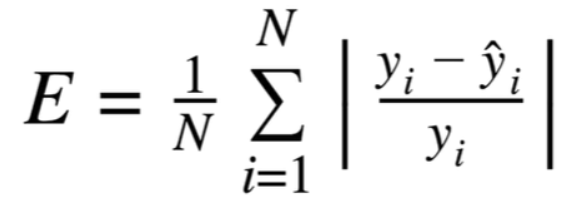

In [39]:
y_pred

[83805.10539854165,
 68751.00370129567,
 66287.87504975768,
 66998.79255977586,
 68615.51399142538,
 69287.93455209259,
 71846.69575563603,
 72764.0832274086,
 71294.39943766304,
 73854.35682776755,
 72868.75619355541,
 72630.66080999636,
 67895.79092605249,
 73393.68411507292,
 73979.57621524576,
 73370.7763527718,
 72492.21629746321,
 73309.45764691423,
 72794.36573978055,
 73300.92176799732,
 78054.88784723922,
 78333.879785605,
 78651.87827630091,
 80323.69621645818,
 82634.38845815329,
 84042.72150808753,
 81829.0830394887,
 82316.15271760224,
 88205.97973449832,
 90509.84488347491,
 91259.70006583793,
 90828.58275661696,
 89667.3077522177,
 87782.08470943183,
 86015.39337128768,
 86960.49158495867,
 86034.80389032565,
 87517.90444109781,
 86937.2950654745,
 91061.61537847533,
 86884.27095539481,
 85329.60707789706,
 83593.94399180441,
 81749.14307951965,
 82241.96350956235,
 83306.52050570742,
 85397.92458297902,
 81820.68997001827,
 82722.86201764124,
 82618.63461767633,
 83308.

In [43]:
print(len(y_pred))
print(len(y_test))

97
97


In [40]:
y_test

day
2020-11-27    68200.0
2020-11-30    66700.0
2020-12-01    67800.0
2020-12-02    69500.0
2020-12-03    69700.0
               ...   
2021-04-14    84000.0
2021-04-15    84100.0
2021-04-16    83900.0
2021-04-19    83300.0
2021-04-20    83900.0
Name: price, Length: 97, dtype: float64

In [41]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y_test, y_pred)

1.8328432691684655

잔차가 실제값의 1.833%를 차지함을 확인할 수 있다.(???)